In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras
import pickle
import os

Using TensorFlow backend.


In [2]:
from LSTM import *
from gen_train_test_data import *
from simtools import *
%load_ext autoreload
%autoreload 2

with open("model/LSTMv2_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        l=pickle.load(f)
        
with open("model/LSTMv2_scaler_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        scaler=pickle.load(f)

D:\Program\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Program\Anaconda2\envs\py3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
for date in test_date_list:
    if not os.path.exists("test_result/x_test_{}.p".format(date)):
        x,idx=create_test_dataset(ticker=ticker,time_steps = time_steps, input_scaler=scaler, date=date)
        print(x.shape,idx.shape)
        
        with open("test_result/x_test_{}.p".format(date),"wb") as f:
                pickle.dump(x,f)
        signal=l.predict(x)
        with open("test_result/signal_test_{}.p".format(date),"wb") as f:
                pickle.dump(signal,f)
    
    log_message( "{} finished".format(date) )

2020-04-27 17:24:09:105844: 20190117 finished
2020-04-27 17:24:09:112231: 20190118 finished
2020-04-27 17:24:09:119041: 20190122 finished
2020-04-27 17:24:09:122870: 20190123 finished
2020-04-27 17:24:09:126276: 20190124 finished
2020-04-27 17:24:09:129177: 20190125 finished
2020-04-27 17:24:09:131723: 20190128 finished
2020-04-27 17:24:09:132878: 20190129 finished
2020-04-27 17:24:09:136080: 20190130 finished
2020-04-27 17:24:09:139438: 20190131 finished


In [9]:
test_taq=dict()

for date in test_date_list:
    if os.path.exists("test_result/x_test_{}.p".format(date)) and os.path.exists(data_dir+"quotes_{}_TSLA.csv".format(date)):

        with open("test_result/signal_test_{}.p".format(date),"rb") as f:
            signal=pickle.load(f)
        # print(signal.shape)
        
        # generate signal and attach it to original df
        signal_discrete=signal.argmax(axis=1)-1
        signal_continuous=np.dot(signal,np.array([[-1],[0],[1]])).ravel()
        
        trades = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])
        N=len(trades)

        signal_discrete=np.concatenate((np.zeros(N-len(signal_discrete))+np.nan,signal_discrete), axis=0)
        signal_continuous=np.concatenate((np.zeros(N-len(signal_continuous))+np.nan,signal_continuous), axis=0)

        trades[["signal_discrete","signal_continuous"]]=pd.DataFrame({"signal_discrete":signal_discrete, "signal_continuous":signal_continuous},index=trades.index)
        # print(trades.shape)
        
        # merge TAQ
        quotes=pd.read_csv(data_dir+"quotes_{}_TSLA.csv".format(date),index_col=[0],parse_dates=[0])
        taq=makeTAQfile(trades, quotes)
        print(trades.shape, quotes.shape)
        print(taq.shape)
        print(trades.shape[0]+quotes.shape[0]-taq.shape[0])
        test_taq[date]=taq
        
        log_message( "{} finished".format(date) )

2020-04-27 17:33:13:208168: start merge
2020-04-27 17:33:13:226120: end merge
(40415, 5) (7436, 7)
(47851, 11)
0
2020-04-27 17:33:13:230109: 20190117 finished
2020-04-27 17:33:13:682465: start merge
2020-04-27 17:33:13:776194: end merge
(267118, 5) (32793, 7)
(299911, 11)
0
2020-04-27 17:33:13:776194: 20190118 finished
2020-04-27 17:33:13:944629: start merge
2020-04-27 17:33:13:991459: end merge
(87978, 5) (12122, 7)
(100100, 11)
0
2020-04-27 17:33:13:991459: 20190124 finished
2020-04-27 17:33:14:138583: start merge
2020-04-27 17:33:14:174487: end merge
(80530, 5) (12479, 7)
(93009, 11)
0
2020-04-27 17:33:14:174487: 20190125 finished
2020-04-27 17:33:14:326083: start merge
2020-04-27 17:33:14:360989: end merge
(71427, 5) (12277, 7)
(83704, 11)
0
2020-04-27 17:33:14:360989: 20190128 finished
2020-04-27 17:33:14:480475: start merge
2020-04-27 17:33:14:511755: end merge
(51738, 5) (8843, 7)
(60581, 11)
0
2020-04-27 17:33:14:511755: 20190129 finished
2020-04-27 17:33:14:774216: start merge

# Test vwap

In [10]:
import vwap2 as vw
matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )
vwap_coefs = [ 9.95503275e-03, -1.01533564e-04,  5.73879785e-07, -1.47027197e-09, 1.38993793e-12]
test_date_list_new=list(test_taq.keys())
day = test_taq[test_date_list_new[0]]
day[~day.bid_px.isna()]

,bid_px,bid_size,ask_px,ask_size,natbbo_ind,qu_source,symbol,trade_size,trade_px,signal_discrete,signal_continuous
2019-01-17 09:30:00.645,346.05,3.0,346.70,8.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 09:30:00.909,346.05,3.0,346.25,1.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 09:30:01.814,346.06,1.0,346.32,1.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 09:30:01.814,346.06,1.0,346.70,8.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 09:30:14.572,345.63,1.0,346.57,1.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-17 15:59:59.629,347.31,26.0,347.49,5.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 15:59:59.779,347.31,27.0,347.49,5.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 15:59:59.779,347.31,28.0,347.49,5.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 15:59:59.780,347.31,29.0,347.49,5.0,4.0,N,TSLA,NaN,NaN,NaN,NaN


In [19]:
from color_txj.color_tao import color_tao as taolaoshi

def test_vwap(day, order_quantity, order_side, schedule_coef = -1.0, tick_coef = 0., LSTM_coef = 1.,LSTM=True):
    results = vw.algo_loop(day, order_side, order_quantity, vwap_coefs, schedule_coef = schedule_coef,\
                           tick_coef = tick_coef, LSTM_coef = LSTM_coef, LSTM=LSTM)
    display_result(results,False)
    return results

def display_result(results,plot=True):
    data = results['trades']
    if plot:
        print("FV and midpoints:")
        plt.plot(results['fair_values'].index,results['fair_values'].values,color=taolaoshi[2])
        plt.plot(results['midpoints'].index,results['midpoints'].values,color=taolaoshi[1])
        plt.legend(["fair_values","midpoints"])
        plt.show()
        print("Trade prices:")
        plt.plot(data.price.index,data.price.values,color=taolaoshi[0])
        plt.show()
    print("percentage of aggressive order:",np.mean(data['trade_type']=="a"))
    print("last_min_order:",results['last_min_order'])
    print("avg price:",results['avg_price'])
    print("day_vwap price:",results['day_vwap'])
    print("avg - day_vwap:",results['avg_price'] - results['day_vwap'])
    
i=0

vwap_list=[]
avg_list_tick=[]
avg_list_LSTM=[]
avg_spread=[]

for date in test_taq.keys():
    print("-------------------------------------------------------------------------------------------------")
    day=test_taq[date]
    r_tick=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -10.0, tick_coef = 1., LSTM_coef = 0.,LSTM=False)
    r_LSTM=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -10.0, tick_coef = 0., LSTM_coef = 1.,LSTM=True)
    
    vwap_list.append(r_LSTM['day_vwap'])
    avg_list_tick.append(r_tick['avg_price'])
    avg_list_LSTM.append(r_LSTM['avg_price'])
    avg_spread.append(r_LSTM["avg_spread"])
    
    log_message( "{} finished".format(date) )
    

-------------------------------------------------------------------------------------------------
2020-04-27 17:58:44:063330: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.2139
2020-04-27 17:58:44:068279: starting main loop
2020-04-27 17:58:57:976705: end simulation loop
2020-04-27 17:58:57:977664: order analytics
2020-04-27 17:58:57:979696: VWAP run complete.
percentage of aggressive order: 1.0
last_min_order: 300.0
avg price: 347.27194333333335
day_vwap price: 347.7717666515837
avg - day_vwap: -0.49982331825032134
2020-04-27 17:58:57:987652: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.2139
2020-04-27 17:58:57:991657: starting main loop
2020-04-27 17:59:14:424308: end simulation loop
2020-04-27 17:59:14:424308: order analytics
2020-04-27 17:59:14:427300: VWAP run complete.
percentage of aggressive order: 0.9873096446700508
last_min_order: 253.0
avg price: 347.2733443333334
day_vwap price: 347.7717666515837
avg - day_vwap: -0.49842231

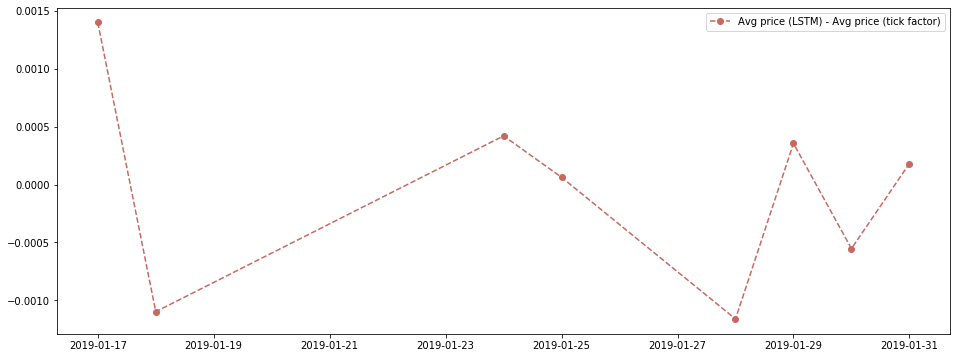

In [20]:
df_compare=pd.DataFrame({"Tick factor":avg_list_tick,"LSTM factor":avg_list_LSTM},index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--',color=taolaoshi[1])
plt.legend(["Avg price (LSTM) - Avg price (tick factor)"])

In [25]:
vwap_list=[]
avg_list_tick=[]
avg_list_LSTM=[]
avg_spread=[]

for date in test_taq.keys():
    print("-------------------------------------------------------------------------------------------------")
    day=test_taq[date]
    r_tick=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -5.0, tick_coef = 0.1, LSTM_coef = 0.,LSTM=False)
    r_LSTM=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -5.0, tick_coef = 0., LSTM_coef = 0.1,LSTM=True)
    
    vwap_list.append(r_LSTM['day_vwap'])
    avg_list_tick.append(r_tick['avg_price'])
    avg_list_LSTM.append(r_LSTM['avg_price'])
    avg_spread.append(r_LSTM["avg_spread"])
    
    log_message( "{} finished".format(date) )

-------------------------------------------------------------------------------------------------
2020-04-27 19:42:13:884008: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.2139
2020-04-27 19:42:13:889994: starting main loop
2020-04-27 19:42:30:241292: end simulation loop
2020-04-27 19:42:30:241292: order analytics
2020-04-27 19:42:30:243287: VWAP run complete.
percentage of aggressive order: 0.8456375838926175
last_min_order: 325.0
avg price: 347.27806166666664
day_vwap price: 347.7717666515837
avg - day_vwap: -0.49370498491703074
2020-04-27 19:42:30:250267: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.2139
2020-04-27 19:42:30:255255: starting main loop
2020-04-27 19:42:48:896432: end simulation loop
2020-04-27 19:42:48:896432: order analytics
2020-04-27 19:42:48:898427: VWAP run complete.
percentage of aggressive order: 0.8235294117647058
last_min_order: 268.0
avg price: 347.2803949
day_vwap price: 347.7717666515837
avg - day_vwap: -0

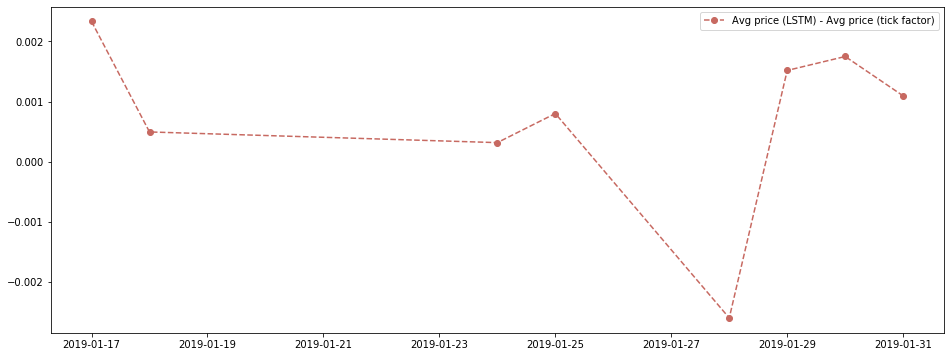

In [26]:
df_compare=pd.DataFrame({"Tick factor":avg_list_tick,"LSTM factor":avg_list_LSTM},index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--',color=taolaoshi[1])
plt.legend(["Avg price (LSTM) - Avg price (tick factor)"])

In [36]:
vwap_list=[]
avg_list_tick=[]
avg_list_LSTM=[]
avg_spread=[]

for date in test_taq.keys():
    print("-------------------------------------------------------------------------------------------------")
    day=test_taq[date]
    r_tick=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -10.0, tick_coef = 1.5, LSTM_coef = 0.,LSTM=False)
    r_LSTM=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -10.0, tick_coef = 0, LSTM_coef = 1.5,LSTM=True)
    
    vwap_list.append(r_LSTM['day_vwap'])
    avg_list_tick.append(r_tick['avg_price'])
    avg_list_LSTM.append(r_LSTM['avg_price'])
    avg_spread.append(r_LSTM["avg_spread"])
    
    log_message( "{} finished".format(date) )

-------------------------------------------------------------------------------------------------
2020-04-27 21:40:02:525989: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.2139
2020-04-27 21:40:02:533010: starting main loop
2020-04-27 21:40:16:421064: end simulation loop
2020-04-27 21:40:16:421064: order analytics
2020-04-27 21:40:16:423062: VWAP run complete.
percentage of aggressive order: 1.0
last_min_order: 300.0
avg price: 347.2720366666667
day_vwap price: 347.7717666515837
avg - day_vwap: -0.4997299849169963
2020-04-27 21:40:16:428007: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.2139
2020-04-27 21:40:16:433992: starting main loop
2020-04-27 21:40:32:803241: end simulation loop
2020-04-27 21:40:32:803241: order analytics
2020-04-27 21:40:32:805236: VWAP run complete.
percentage of aggressive order: 0.9848101265822785
last_min_order: 252.0
avg price: 347.2733460333333
day_vwap price: 347.7717666515837
avg - day_vwap: -0.4984206182

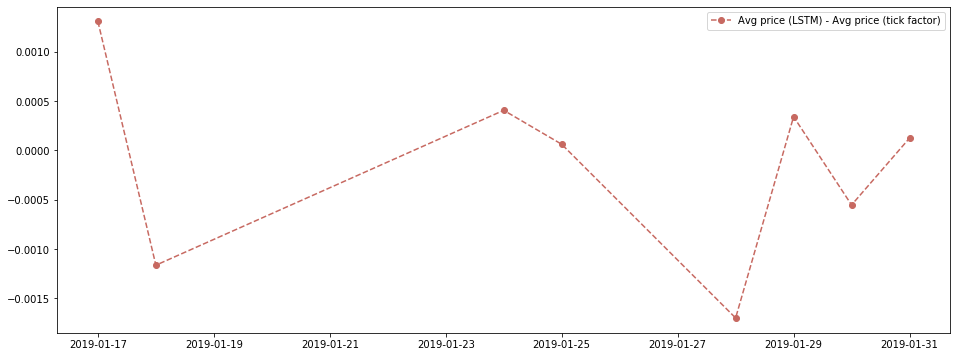

In [37]:
df_compare=pd.DataFrame({"Tick factor":avg_list_tick,"LSTM factor":avg_list_LSTM},index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--',color=taolaoshi[1])
plt.legend(["Avg price (LSTM) - Avg price (tick factor)"])